In [1]:
import meteva.base as meb
import numpy as np
import pandas as pd
import math
import copy
import datetime
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from meteva.base.tool.plot_tools import add_china_map_2basemap

In [2]:
import sys
#import mode
sys.path.append(r'F:\Work\MODE\Submit')
import make_spatialVx, centmatch, feature_finder, merge_force, plot
import minboundmatch, feature_axis,feature_match_analyzer, interester, deltamm
import feature_match_analyzer, feature_props, feature_comps, utils, feature_table

# MODE概述
----------------------
<font face="黑体" color=Black size=5>
<br> MODE方法是在定义并计算降水对象的不同属性的基础上，设定不同属性的权重系数，运用模糊<br>  
<br> 逻辑算法计算预报性能的总收益函数从而判断预报的整体表现。<br>  </font>  
<font face="黑体" color=Black size=4>
<br> 计算流程如下：<br>  
<br> step1：读取观测和预报数据，利用make_spatialVx函数整理数据以及数据属性。<br>  
<br> step2：观测场和预报场平滑、雨量阈值提取、选取关注的降雨面积最大最小值，提取目标。<br>  
<br> step3：通过目标质心距离、目标面积、最小边界距离等属性，将相似的观测场和预报场目标进行匹配。<br>  
<br> step4：观测场和预报场目标存在多对多的情况，将多对多的目标进行合并。<br>  
<br> step5：计算目标的多种属性，如凸包点坐标、面积、长短轴长度、方位角等。<br>  
<br> step6：通过观测场和预报场的目标属性，计算观测和预报的可信度矩阵。假定阈值为0.7，则0.7或以上表示该模式有一定的<br>   
<br> 预报能力。<br>  </font>  

<font face="黑体" size=3>本示例选用的是2020年7月2日08时的过去24小时累积雨量与预报雨量，格点分辨率为0.25°经度范围是70°E至140°E，纬度范围是15°N至55°N，覆盖中国范围。</font>

In [3]:
#读取观测和预报数据
filename_ob = r'F:\\Work\\MODE\\Submit\\mode_data\\ob\\rain03\\20070111.000.nc'    
filename_fo = r'F:\\Work\\MODE\\Submit\\mode_data\\ec\\rain03\\20070108.003.nc'

grd_ob = meb.read_griddata_from_nc(filename_ob)
grd_fo = meb.read_griddata_from_nc(filename_fo)

# feature_finder

## feature_finder函数功能以及参数说明
--------------------------------------------------------
<font face="黑体" color=Black size=3> **函数功能：格点数据平滑，雨量阈值控制**</font>  
<font face="黑体" color=Blue size=3>**look_ff = feature_finder(grd_ob, grd_fo, smooth, threshold, minsize, maxsize = float("Inf"), do_smooth = True )**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>filename_ob</font>**|观测数据文件||
|**<font face="黑体" color=Blue size=5>filename_fo</font>**|预报数据文件||
|**<font face="黑体" color=Blue size=5>smooth</font>**|平滑系数|需要输入整数，可以为列表或者数组形式，观测场和预报场可以选择不同的平滑系数，如smooth = [5, 4]，平滑系数的最小值为1，如果不做平滑需要将do_smooth设置为False。|
|**<font face="黑体" color=Blue size=5>threshold</font>**|雨量阈值|可以输入整数或者小数，为列表或者数组形式，观测场和预报场也可以选择不同的雨量阈值，如threshold = [5.2*9, 2.3*7]。需要说明的是，由于平滑算法的问题，原始场的雨量在平滑后被扩大数倍，因而阈值列表中的前一位小数（如5.2， 2.3）表示雨量阈值，后一位整数（如9，7）表示倍数。
|**<font face="黑体" color=Blue size=5>minsize</font>**|目标的最小面积|需要输入整数，可以为列表或者数组形式，观测场和预报场可以选择不同的最小面积，如minsize = [5, 4]，此列表中的数值表示的是格点数。
|**<font face="黑体" color=Blue size=5>maxsize</font>**|目标面积的最大值|默认为无穷大
|**<font face="黑体" color=Blue size=5>do_smooth</font>**|是否需要平滑|如果不需要平滑，则设为False, 如果需要平滑，则设为True。

## feature_finder函数调用示例
------------------------------------------------

In [8]:
#当smoothpar平滑次数较小时，thresh的值扩大的倍数小,小于1，如果平滑次数较大，则thresh阈值扩大了30倍左右

look_ff = feature_finder.feature_finder(grd_ob = grd_ob, 
                                        grd_fo = grd_fo,
                                        smooth = [6, 5],
                                        threshold = [5*9, 4*7],
                                        minsize = [5, 5])
print("*** 计算完毕 ***\n")

*** 计算完毕 ***



In [9]:
#打印结果
#look_ff

## feature_finder函数计算结果
--------------------------------------------

|变量|说明|备注|
|:---|:--:|:---|
|grd_ob|原始观测场|无坐标信息|
|**<font face="黑体" color=Blue size=5>grd_ob_labeled</font>**|观测场被标记的目标|经过平滑、雨量阈值过滤、面积筛选后保留下来的被标记的目标|
|**<font face="黑体" color=Blue size=5>grd_ob_features</font>**|观测场被标记的目标(每个目标单独存放)以及属性|经过平滑、雨量阈值过滤、面积筛选后保留下来的被标记的目标|
|grd_ob_prop|观测场被标记目标的属性信息|包括面积、质心坐标、外接多边形面积、长短轴长度、图形矩等|
|grd_fo|原始预报场|无坐标信息|
|**<font face="黑体" color=Blue size=5>grd_fo_labeled</font>**|预报场被标记的目标|经过平滑、雨量阈值过滤、面积筛选后保留下来的被标记的目标|
|**<font face="黑体" color=Blue size=5>grd_fo_features</font>**|预报场被标记的目标(每个目标单独存放)以及属性|经过平滑、雨量阈值过滤、面积筛选后保留下来的被标记的目标|
|grd_fo_prop|预报场被标记目标的属性信息|包括面积、质心坐标、外接多边形面积、长短轴长度、图形矩等|
|loc|坐标信息|
|identifier_label|Convolution Threshold|卷积阈值|

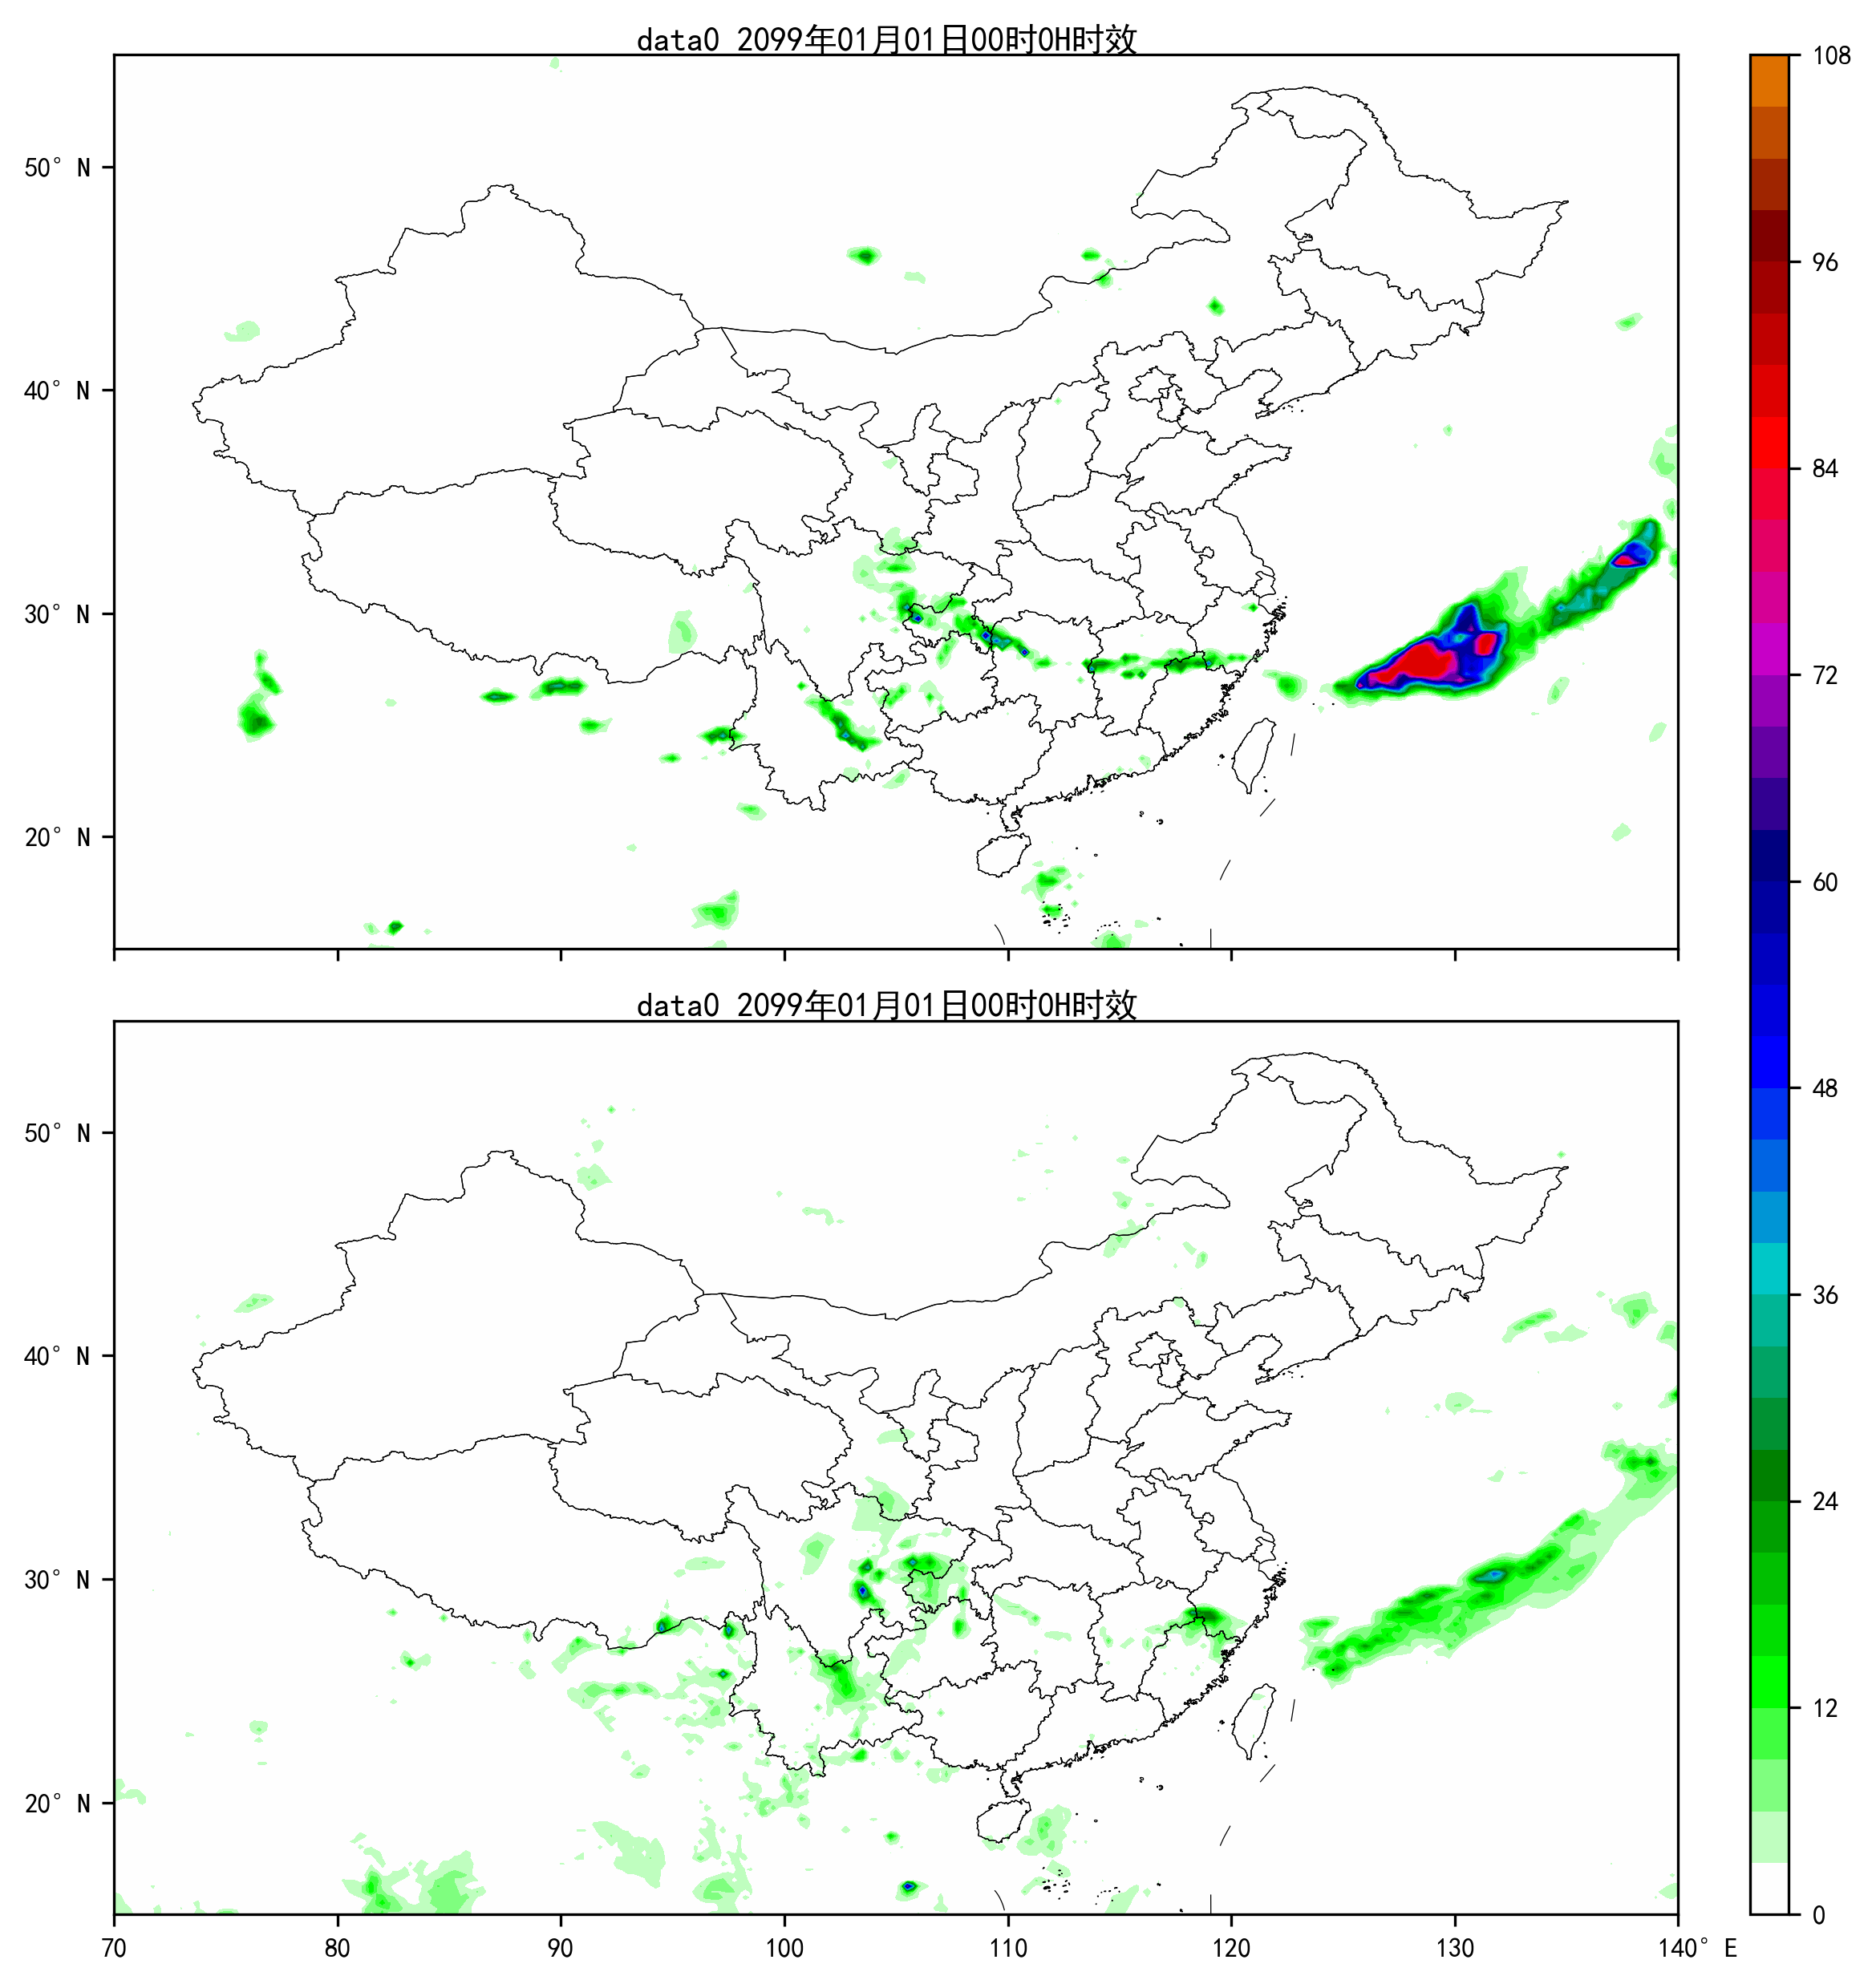

In [10]:
#用xarray读取观测数据集是为了获取坐标范围
dataset_ob = xr.open_dataset(filename_ob)

#绘制原始观测场和预报场
plot.plot_values(dataset_ob, grd_ob = look_ff['grd_ob'], 
                 grd_fo = look_ff['grd_fo'], cmap = "rain_3h")

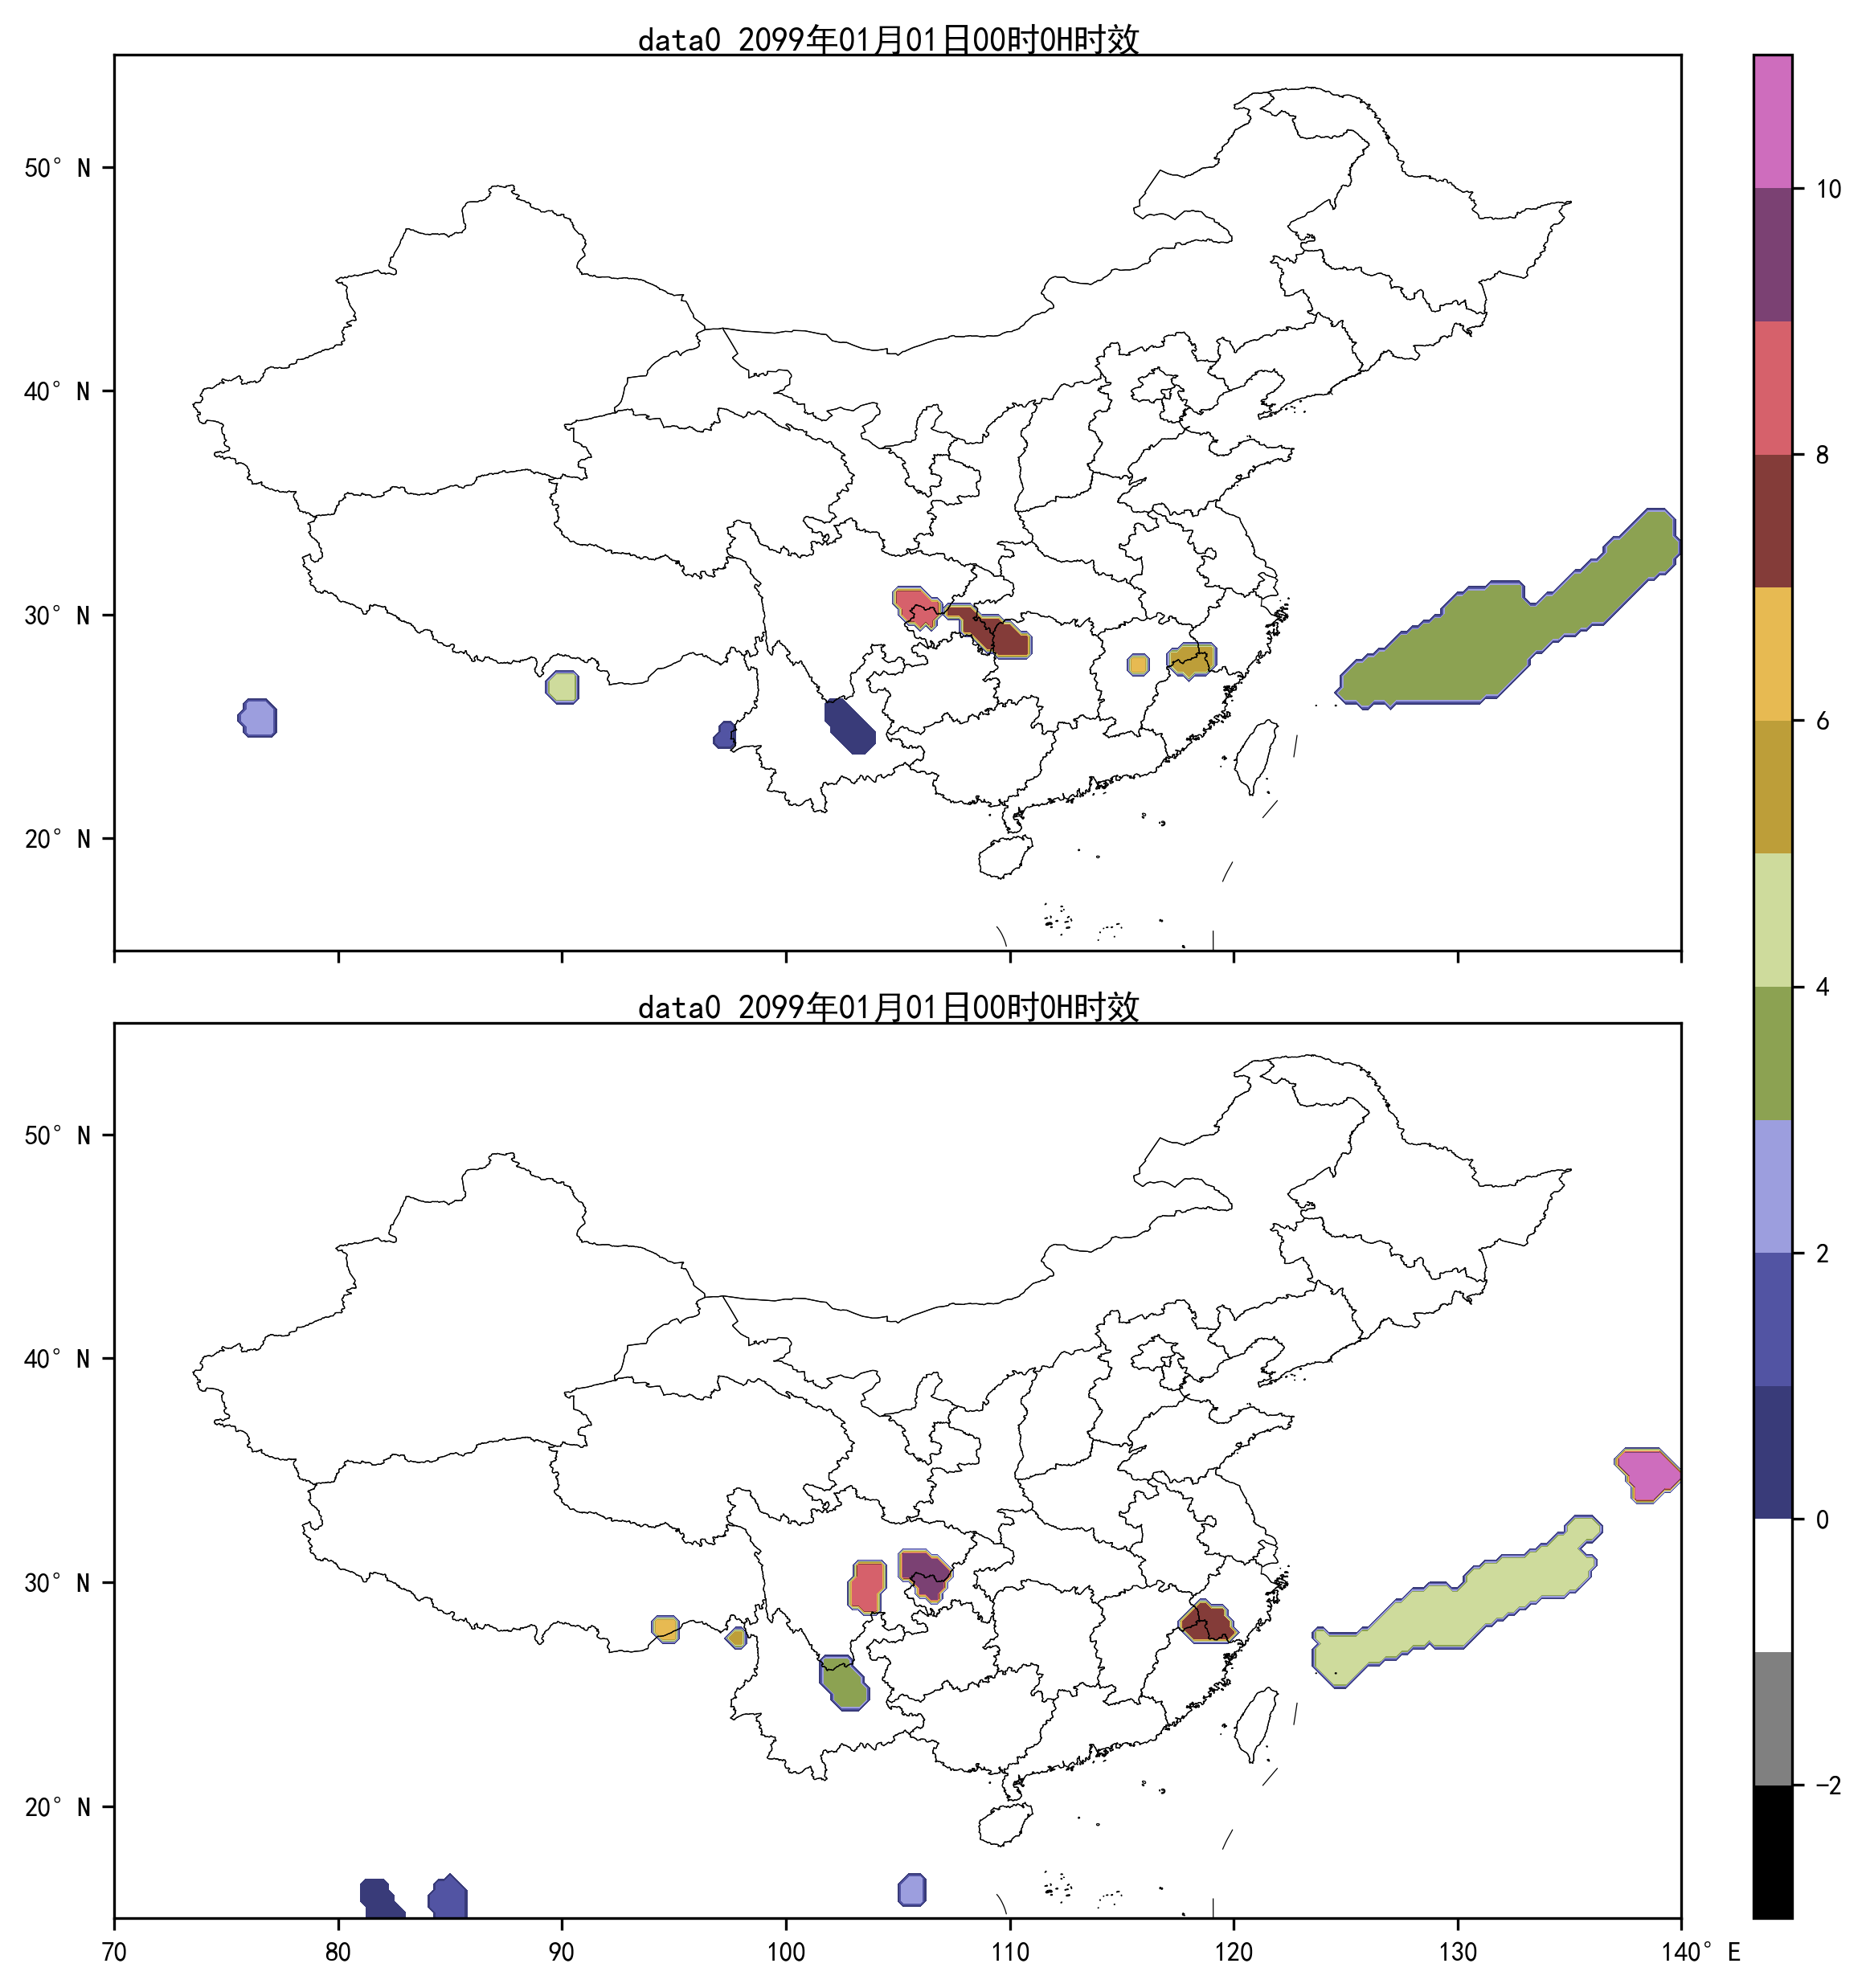

In [11]:
#绘制提取后的目标
plot.plot_ids(dataset_ob, grd_ob = look_ff['grd_ob_labeled'], 
              grd_fo = look_ff['grd_fo_labeled'])

<font face="黑体" color=Black size=4> **为了说明方便，本示例将feature_finder结果中的结果进行手动标记，如下图：**</font>  
**<font face="黑体" color=Blue size=4> 需要说明的是，观测场和预报场中的目标都是从0开始标记的，后续对比、匹配计算都是基于该序号，例如centmatch函数计算结果中的matches/unmatched/implicit_merge等结果中的数字都是表示该目标的序号。</font>**  
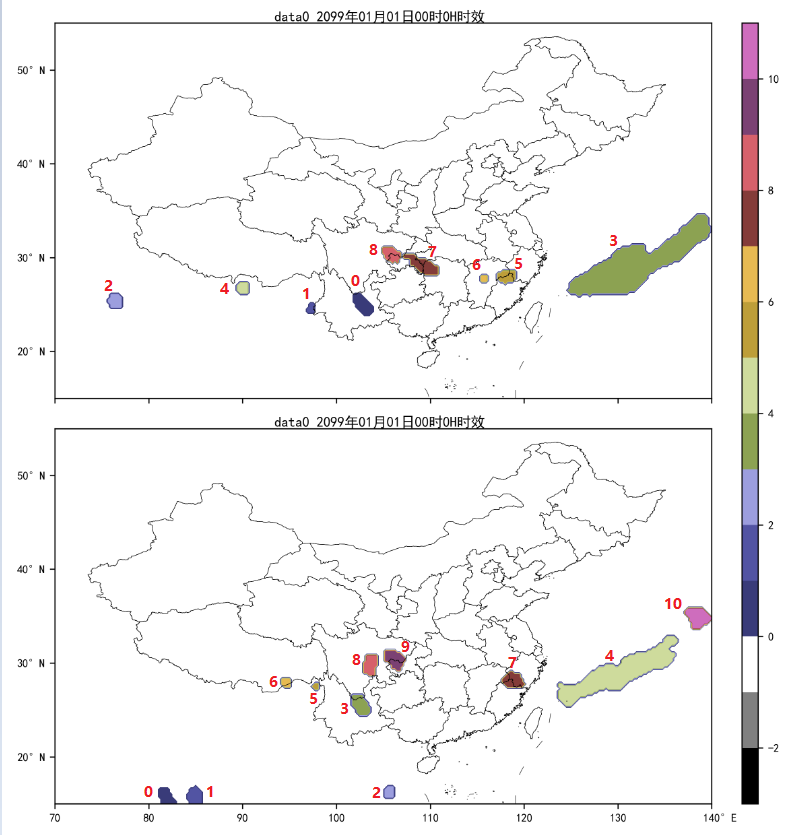

# centmatch

## centmatch函数功能以及参数说明
---------------------------------------------------
<font face="黑体" color=Black size=4> **函数功能：将观测场和预报场满足条件的目标匹配，匹配准则为当两个场中对象的质心距离D小于其尺度之和，判定这两个目标的空间位置是否对应。**</font>  
<font face="黑体" color=Blue size=4>**look_centmatch = centmatch(look_ff, criteria = 1, const = 14, areafac = 1, verbose = False)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>look_ff</font>**|feature_finder函数结果|数据为dict格式|
criteria|
const|
areafac|
verbose|是否需要将计算过程中的一些信息打印在屏幕|默认为False,当verbose=True，则将计算过程中的提示信息打印在屏幕

## centmatch函数调用示例
---------------------------------------

In [10]:
look_centmatch = centmatch.centmatch(look_ff = look_ff)
print("*** 计算完毕 ***\n")

*** 计算完毕 ***



In [11]:
#打印计算结果
#look_centmatch

## centmatch函数计算结果
---------------------------------------------
<font face="黑体" color=Blue size=4> **centmatch的结果中grd_ob/grd_fo,grd_ob_features/grd_fo_features,grd_ob_labeled/grd_fo_labeled,
grd_ob_prop/grd_fo_prop,loc是从look_ff参数中继承下来，属性同上，因而不再赘述，这里主要介绍centmatch有关的计算结果。**</font>  

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>centroid_distances</font>**|观测场和预报场目标之间的质心距离|numpy数组|
|**<font face="黑体" color=Blue size=5>criteria_values</font>**|观测场和预报场面积开方和|numpy数组|
|**<font face="黑体" color=Blue size=5>implicit_merges</font>**|观测场和预报场匹配结果|多对多的匹配结果|
|matches|观测场和预报场匹配目标序号|与implicit_merges结果相同，只是存放形式不一样，一个是列表形式，一个是数组|
|unmatched|观测场(grd_ob)和预报场(grd_fo)没有匹配的目标序号|整数集合|
|match_message|匹配的提示信息|字符串格式|
|match_type|匹配类型，为匹配函数的名称|字符串格式|
|MergeForced|是否合并|该函数默认为未合并|

# mergeforce

## mergeforce函数参数以及说明
---------------------------------------------------
<font face="黑体" color=Black size=4> **函数功能：将匹配过的目标合并。**</font>  
<font face="黑体" color=Blue size=4>**look_mergeforce = merge_force(look_match, show=False)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>look_match</font>**|观测场和预报场目标匹配结果|可以是centmatch函数结果|
|verbose|是否需要将计算过程中的一些信息打印在屏幕|默认为False,当verbose=True，则将计算过程中的提示信息打印在屏幕|

## mergeforce函数调用示例
----------------------------------------

In [14]:
look_mergeforce = merge_force.merge_force(look_match = look_centmatch.copy())
print("*** 计算完毕 ***\n")

*** 计算完毕 ***



## mergeforce函数计算结果
---------------------------------------------
<font face="黑体" color=Blue size=4>**mergeforce的结果中grd_ob/grd_fo为原始的观测场和预报场,是从参数中继承下来的,此处不加赘述。  
其中,grd_ob_labeled/grd_fo_labeled,grd_ob_features/grd_fo_features是合并后的标记目标。**</font>  

In [15]:
#打印计算结果
#look_mergeforce

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>grd_ob_features</font>**|观测场被标记的目标(每个目标单独存放)|合并后的目标|
|**<font face="黑体" color=Blue size=5>grd_fo_features</font>**|预报场被标记的目标(每个目标单独存放)|合并后的目标|
|**<font face="黑体" color=Blue size=5>grd_ob_labeled</font>**|观测场合并后的标记目标|匹配、合并后的目标|
|**<font face="黑体" color=Blue size=5>grd_fo_labeled</font>**|预报场合并后的标记目标|匹配、合并后的目标|
|matches|观测场和预报场的匹配目标序号||
|unmatched|观测场和预报场未匹配的目标序号||

# 其他匹配规则
<font face="黑体" color=Black size=4> MODE方法中有三种目标匹配规则，上面已经提到一种匹配规则，另外两种分别是：质心距离匹配（deltamm函数）和最小边界匹配（minboundmatch函数）。</font>  

# deltamm

## deltamm函数参数以及说明
------------------------------------------------
<font face="黑体" color=Black size=4> **函数功能：以观测场为准，将观测场目标和预报场目标按照质心距离进行匹配。**</font>  
<font face="黑体" color=Blue size=4>**look_deltamm = deltamm(look_ff, p = 2, verbose = False)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>look_deltamm</font>**|featureFinder函数结果|可以是平滑、阈值提取后的目标|
|p|
|verbose|是否需要将计算过程中的一些信息打印在屏幕|默认为False,当verbose=True，则将计算过程中的提示信息打印在屏幕|

## deltamm函数调用示例
--------------------------------------

In [23]:
look_deltamm = deltamm.deltamm(look_ff = look_ff.copy())
print("*** 计算完毕 ***")

*** 计算完毕 ***


## deltamm函数计算结果
------------------------------------

In [16]:
#打印计算结果
#look_deltamm

<font face="黑体" color=Blue size=4> **deltamm的结果中grd_ob/grd_fo,grd_ob_features/grd_fo_features,grd_ob_labeled/grd_fo_labeled,
grd_ob_prop/grd_fo_prop,loc，identifier_label是从参数中继承下来,属性同上。  
deltamm函数主要是距离计算，观测场目标和预报场目标的一一对比结果存放在变量Q中，目前deltamm的匹配结果为一对一。**</font>  

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>match_type</font>**|匹配函数名称|
|**<font face="黑体" color=Blue size=5>Q</font>**|观测场和预报场目标之间的质心距离（三维矩阵）|第一层:观测场目标和预报场目标一一对应的质心距离；第二层:以观测场为准，剔除质心距离最小的目标，再计算合并后的不同目标之间的质心距离；第三层:以预报场为准，剔除质心距离最小的目标，再计算合并后的不同目标之间的质心距离
|**<font face="黑体" color=Blue size=5>matches</font>**|以预报场为准的目标匹配序号
|**<font face="黑体" color=Blue size=5>unmatched</font>**|未匹配的目标序号
|**<font face="黑体" color=Blue size=5>ob_matches</font>**|以观测场为准的目标匹配序号|
|merges|需要合并的目标序号|
|MergeForce|是否合并|该函数输出结果显示已合并，但是实际上没有合并|
|match_message|匹配信息|

# minboundmatch

## minboundmatch函数功能以及参数说明
------------------------------------------------------------
<font face="黑体" color=Black size=4> **函数功能：按照最小边界距离，将观测场目标和预报场目标进行匹配。虽然该函数计算得到的也是匹配结果，但是输入合并函数里并没有进行实际的合并，而是直接返回输入的结果。**</font>  
<font face="黑体" color=Blue size=4>**look_minboundmatch = minboundmatch(look_ff, mindist = float('inf'), verbose = False)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>look_ff</font>**|featureFinder函数结果|minboundmatch函数主要读取的是单独存放的目标矩阵，然后进行一一对比计算|
|**<font face="黑体" color=Blue size=5>mindist</font>**|最小匹配距离|默认为无穷大|

## minboundmatch函数调用示例
-----------------------------------------------

In [28]:
look_minboundmatch = minboundmatch.minboundmatch(look_ff = look_ff.copy())
print("*** 计算完毕 ***")

*** 计算完毕 ***


## minboundmatch函数计算结果
------------------------------------------------

In [ ]:
#打印计算结果
#look_minboundmatch

<font face="黑体" color=Blue size=4> **minboundmatch的结果中grd_ob/grd_fo,grd_ob_features/grd_fo_features,grd_ob_labeled/grd_fo_labeled,
grd_ob_prop/grd_fo_prop,loc，identifier_label是从参数中继承下来,属性同上。  
minboundmatch函数主要是边界距离计算，观测场目标和预报场目标的一一对比结果存放在变量values中。**</font>  

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>match_type</font>**|匹配函数名称|
|**<font face="黑体" color=Blue size=5>values</font>**|每个目标之间的最小边界距离|dataframe类型，前两列为观测场和预报场的目标序号，第三列为最小边界距离|
|**<font face="黑体" color=Blue size=5>matches</font>**|匹配结果|dataframe类型，两列分别为观测场和预报场的目标序号|
|merge_force|是否合并|该函数的匹配结果没有合并|
|unmatched|没有匹配的目标序号|
|match_message|匹配信息|

# feature_axis

## feature_axis函数功能以及参数说明
------------------------------------------------------
<font face="黑体" color=Black size=4> **函数功能：计算某一独立目标的轴属性，属性包括：在平面坐标系上长短轴起始点坐标、长短轴重点坐标、长短轴长度、长短轴之比、长短轴角度、凸包点坐标等。**</font>  
<font face="黑体" color=Blue size=4>**look_featureaxis = feature_axis(grd_feature, fac=1, flipit=False, twixt=False)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>grd_feature</font>**|观测场或者预报场中某个独立的目标|单独存放的二值化矩阵|
|fac| | |
|flipit|原始的格点场是否需要翻转|默认为False|
|twixt|是否应强制主轴角度在正负90度之间|默认为FALSE|

## feature_axis函数调用示例
-----------------------------------------

In [29]:
#feature_axis函数输入的是观测场或者预报场中单个的目标
Xtmp = {"m": look_ff['grd_fo_features']['labels_1']}
Ytmp = {"m": look_ff['grd_ob_features']['labels_1']}
look_featureaxis = feature_axis.feature_axis(grd_feature = Xtmp)
print("*** 计算完毕 ***")

*** 计算完毕 ***


## feature_axis函数计算结果
-------------------------------------------

In [32]:
#打印计算结果
#look_featureaxis

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>MajorAxis</font>**|平面坐标系上，长轴的起始点坐标|
|**<font face="黑体" color=Blue size=5>MinorAxis</font>**|平面坐标系上，短轴的起始点坐标|
|**<font face="黑体" color=Blue size=5>MidPoint</font>**|平面坐标系上，长短轴的中点坐标|
|**<font face="黑体" color=Blue size=5>OrientationAngle</font>**|长轴和短轴的角度|
|**<font face="黑体" color=Blue size=5>aspect_ration</font>**|长短轴长度之比|
|**<font face="黑体" color=Blue size=5>pts</font>**|凸包点坐标|二维数组存放
|<font face="黑体" color=Blue size=5>**chull**</font>|凸包点坐标|三维数组存放|
|**<font face="黑体" color=Blue size=5>sma_fit</font>**|计算长短轴时,进行拟合得到的拟合函数的相关参数|包括系数、截距、斜率、以及起始点
|phi|
|point|

# feature_props

## feature_props函数功能以及参数说明
----------------------------------------------------


<font face="黑体" color=Black size=4> **函数功能：计算某一个独立的目标的面积、轴、质心、强度属性，其中轴的属性是通过feature_axis函数计算出来的，计算内容与其一致。**</font>  
<font face="黑体" color=Blue size=4>**look_featureprops = feature_props(grd_feature, im=None, which_comps=None, areafac=1, q=None, loc=None)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>grd_feature</font>**|独立的观测场或者预报场的目标|二值化矩阵|
|**<font face="黑体" color=Blue size=5>grd_feature</font>**|独立的观测场或者预报场的目标|二值化矩阵|

## feature_props函数调用示例
--------------------------------------------

In [34]:
look_featureprops = feature_props.feature_props(grd_feature = Xtmp, which_comps = ["centroid", "area", "axis"])
print("*** 计算完毕 ***")

*** 计算完毕 ***


## feature_props函数计算结果
-----------------------------------------  


In [36]:
#打印计算结果
#look_featureprops

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>area</font>**|目标的面积|
|**<font face="黑体" color=Blue size=5>axis</font>**|轴的属性|属性内容请参考feature_axis结果|
|**<font face="黑体" color=Blue size=5>centroid</font>**|质心坐标|经纬度坐标|

# feature_comps

## feature_comps函数功能你以及参数说明
---------------------------------------------------------


<font face="黑体" color=Black size=4> **函数功能：计算某一个独立的目标的面积、轴、质心、强度属性，其中轴的属性是通过feature_axis函数计算出来的，计算内容与其一致。**</font>  
<font face="黑体" color=Blue size=4>**feature_comps(grd_fo, grd_ob, which_comps=None, sizefac=1, alpha=0.1, k=4, p=2, c=float('inf'), distfun='distmapfun',deg=True, aty='compass', loc=None)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>grd_fo</font>**|独立的预报场目标|
|**<font face="黑体" color=Blue size=5>grd_ob</font>**|独立的观测场目标|
|**<font face="黑体" color=Blue size=5>which_comps</font>**|需要计算的属性，默认为["cent.dist", "angle.diff", "area.ratio", "int.area", "bdelta","haus", "ph", "med", "msd", "fom","minsep", "bearing"]|

## feature_comps调用示例
-------------------------------------

In [40]:
XtmpAttributes = utils.get_attributes_for_feat(look_ff['grd_ob_features'])
remove_list = ['Type', 'xrange', 'yrange', 'dim', 'xstep', 'ystep', 'warnings', 'xcol', 'yrow']    #需要移除的属性列表
xkeys = utils.remove_key_from_list(list(look_ff['grd_ob_features'].keys()), remove_list)
Xtmp.update(XtmpAttributes)

YtmpAttributes = utils.get_attributes_for_feat(look_ff['grd_fo_features'])
ykeys = utils.remove_key_from_list(list(look_ff['grd_fo_features'].keys()), remove_list)
Ytmp = {"m": look_ff['grd_fo_features']['labels_1']}
Ytmp.update(YtmpAttributes)

look_featurecomps = feature_comps.feature_comps(grd_ob= Xtmp, grd_fo = Ytmp)
print("*** 计算完毕 ***\n")

*** 计算完毕 ***



## feature_comps函数计算结果
------------------------------------------

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>cent.dist</font>**|质心距离|
|**<font face="黑体" color=Blue size=5>angle.diff</font>**|角度差|
|**<font face="黑体" color=Blue size=5>area.ratio</font>**|面积比|
|**<font face="黑体" color=Blue size=5>int.area</font>**|交叉面积|
|**<font face="黑体" color=Blue size=5>bdelta</font>**||
|**<font face="黑体" color=Blue size=5>haus</font>**|角度差|
|**<font face="黑体" color=Blue size=5>ph</font>**|角度差|
|**<font face="黑体" color=Blue size=5>med</font>**|平均误差距离|
|**<font face="黑体" color=Blue size=5>msd</font>**|均方误差距离|
|**<font face="黑体" color=Blue size=5>fom</font>**|角度差|
|**<font face="黑体" color=Blue size=5>minsep</font>**|最小间隔距离|
|**<font face="黑体" color=Blue size=5>bearing</font>**|预报目标质心到观测目标质心的方位角|

# feature_match_analyzer

## feature_match_analyzer函数功能以及参数说明
------------------------------------------------------
<font face="黑体" color=Black size=4> **函数功能：计算所有目标的相关属性,该函数主要是调用feature_comps计算，与feature_comps的区别是：feature_comps是计算单个目标的相关属性，本函数是计算多个匹配目标的相关属性，具体的说明，可参考feature_comps。**</font>  
<font face="黑体" color=Blue size=4>**look_featureMatcanalyzer = feature_match_analyzer(look_match, which_comps=None, sizefac=1, alpha=0.1, k=4, p=2, c=float("inf"), distfun="distmapfun", y=None, matches=None, object=None)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>look_match</font>**|匹配结果|
|**<font face="黑体" color=Blue size=5>which_comps</font>**|需要计算的属性，默认为["cent.dist", "angle.diff", "area.ratio", "int.area", "bdelta","haus", "ph", "med", "msd", "fom","minsep", "bearing"]|

## feature_match_analyzer函数调用示例
-------------------------------------------------------------

In [42]:
look_featureMatcanalyzer = feature_match_analyzer.feature_match_analyzer(look_match = look_centmatch.copy())
print("*** 计算完毕 ***")

*** 计算完毕 ***


## feature_match_analyzer函数计算结果
-------------------------------------------------------
<font face="黑体" color=Blue size=4> **本函数是对多个匹配结果计算属性，属性内容同feature_comps，具体的说明，可参考feature_comps。**</font>  

# feature_table

## feature_table函数功能以及参数说明
-----------------------------------------------------
<font face="黑体" color=Black size=4> **函数功能：在目标匹配的基础上，针对匹配结果计算评分和标准差等。**</font>  
<font face="黑体" color=Blue size=4>**feature_table = feature_table(grd_features, fudge=1e-08, hits_random=None, correct_negatives=None, fA=0.05)**</font>

|参数|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>grd_features</font>**|目标匹配结果|

## feature_table函数调用示例

In [44]:
look_featuretable = feature_table.feature_table(grd_features = look_centmatch.copy())
print("*** 计算完毕 ***\n")

*** 计算完毕 ***



## feature_table函数计算结果

In [46]:
#打印计算结果
#look_featuretable

|变量|说明|备注|
|:---|:--:|:---|
|**<font face="黑体" color=Blue size=5>estimate</font>**|匹配结果|

In [ ]:
look_interester = interester.interester(x = look_featureFinder.copy())
print("*** 计算完毕 ***\n")